# Wine Spirit

Vous êtes Développeur IA indépendant chez un marchand de vins de renom qui dispose d’un site internet pour ses ventes. Votre rôle est d’accompagner votre client dans sa transformation digitale. En effet pour le moment plusieurs painpoint sont présents. Par exemple, l’ERP utilisé n’est pas connecté au site internet : l’analyse des ventes sur internet est impossible, les outils sont rudimentaires, ect...

### Import

Dans un premier temps j'importe les bibliothèques dont je vais avoir besoin (pandas, numpy).

J'importe également les données dans des DataFrames.

Je nettoie les doublons de la DataFrame 'df_web' et renome l'index 'sku' en 'id_web' pour facilité le merge futur.

In [15]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans, vq, whiten

%matplotlib inline

df_erp = pd.read_excel(r'Ressources\erp.xlsx')
df_liaison = pd.read_excel(r'Ressources\liaison.xlsx')
df_web = pd.read_excel(r'Ressources\web.xlsx')

df_web = df_web.drop_duplicates()
df_web.rename(columns={'sku': 'id_web'},inplace=True)

### Merging

Je joints les DataFrames importé précédemment en un seul pour facilité la visualisation des corrélations.

In [2]:
df_liaison = df_liaison.dropna()
df_merge = df_erp.merge(df_liaison)
df_merge = df_merge.merge(df_web)

### Analyse

Avec un 'describe' on peut mettre en avant les colonnes vides (NaN) et les colonnes composé de valeur unique.

J'ai aussi utilisé 'pandas profiling' pour extraire toutes les données au format HTML et avoir une visualisation rapide des données. Cela permet d'avoir un premier aperçu.

In [3]:
print(df_merge.describe())
html = ProfileReport(df_merge,
                     title="Wine Spirit Report",
                     explorative=True,
                     correlations={"cramers": {"calculate": False}})
html.to_file("Wine_Spirit.html")

        product_id  onsale_web        price  stock_quantity  virtual  \
count  1428.000000      1428.0  1428.000000     1428.000000   1428.0   
mean   5032.557423         1.0    32.493137       28.746499      0.0   
std     790.233846         0.0    27.800779       47.995782      0.0   
min    3847.000000         1.0     5.200000        0.000000      0.0   
25%    4280.000000         1.0    14.100000        2.000000      0.0   
50%    4796.000000         1.0    23.550000       12.000000      0.0   
75%    5711.000000         1.0    42.200000       35.000000      0.0   
max    7338.000000         1.0   225.000000      578.000000      0.0   

       downloadable  rating_count  average_rating  total_sales  tax_class  \
count        1428.0        1428.0          1428.0  1428.000000        0.0   
mean            0.0           0.0             0.0     4.012605        NaN   
std             0.0           0.0             0.0     8.515198        NaN   
min             0.0           0.0          

### Suppression 

Suite à l'analyse précédemment effectué je me permet de supprimer toutes les colonnes qui n'ont aucunes valeurs (NaN) et les colonnes qui ont une valeur unique.

Je drop ensuite les lignes qui contiennent des valeurs nulles (NaN) qui ne pourront pas être utiliser.

In [4]:
df_drop = df_merge.drop(columns=['post_content_filtered',
                                 'post_password',
                                 'tax_class',
                                 'post_content',
                                 'post_mime_type',
                                 'id_web',
                                 'virtual',
                                 'downloadable',
                                 'rating_count',
                                 'average_rating',
                                 'tax_status',
                                 'post_status',
                                 'comment_status',
                                 'ping_status',
                                 'post_parent',
                                 'menu_order',
                                 'post_type',
                                 'comment_count'])
df_drop = df_drop.dropna()

In [5]:
df_drop.dtypes

product_id                    int64
onsale_web                    int64
price                       float64
stock_quantity                int64
stock_status                 object
total_sales                 float64
post_author                 float64
post_date            datetime64[ns]
post_date_gmt        datetime64[ns]
post_title                   object
post_excerpt                 object
post_name                    object
post_modified        datetime64[ns]
post_modified_gmt    datetime64[ns]
guid                         object
dtype: object

In [6]:
df_drop['chiffre_affaire'] = df_drop['total_sales'] * df_drop['price']
print("Le chiffre d'affaire par produit est : ")
print(df_drop['chiffre_affaire'])
# print(df_drop['chiffre_affaire'][df_drop.chiffre_affaire != 0])
chiffre = sum(df_drop['chiffre_affaire'])
print("le chiffre d'affaire total est : " 
      + str(chiffre) + " €")

Le chiffre d'affaire par produit est : 
0       145.2
2         0.0
4         0.0
6        42.3
8         0.0
        ...  
1418     42.0
1420      0.0
1422      0.0
1424      0.0
1426      0.0
Name: chiffre_affaire, Length: 714, dtype: float64
le chiffre d'affaire total est : 70568.6 €


### Outliers

Maintenant nous allons nous pencher sur les outliers en utilisant les 4 méthodes proposés par l'énoncé.

##### Méthode Z Score :

In [7]:
z_score = stats.zscore(df_drop['price'])
df_drop['outliers'] = (z_score > 2)
print("Par la méthode Z_score on trouve " 
      + str(len(z_score[z_score>2])) 
      + " outliers.")
print('Les outliers sont : ')
print(df_drop['price'][df_drop['outliers']==True])

Par la méthode Z_score on trouve 30 outliers.
Les outliers sont : 
126     100.0
130      88.4
398     225.0
402     126.5
436     176.0
438     108.5
442     157.0
444     104.0
454     109.6
760     102.3
762     137.0
852     217.5
862     105.0
864     105.0
874     112.0
1004     92.0
1022    124.8
1106    175.0
1174    191.3
1204     93.0
1206    122.0
1208    114.0
1284    135.0
1294    105.6
1296    116.4
1306    115.0
1308    121.0
1310     99.0
1312    115.0
1314    121.0
Name: price, dtype: float64


##### Méthode des interquartiles : 

In [8]:
q3, q1 = np.percentile(df_drop['price'], [75 ,25])
iqr = q3 - q1
outliers = df_drop['price'][(df_drop['price'] < q1 - 1.5 * iqr)
                            |(df_drop['price'] > q3 + 1.5 * iqr)]
print("L'interquantiles est égal à " 
      + str(iqr) 
      + ".")
print("Par la méthode interquartiles on trouve " 
      + str(len(outliers)) 
      + " outliers.")
print("Les outliers sont :")
print(outliers)

L'interquantiles est égal à 28.075000000000003.
Par la méthode interquartiles on trouve 32 outliers.
Les outliers sont :
126     100.0
130      88.4
398     225.0
402     126.5
410      85.6
436     176.0
438     108.5
442     157.0
444     104.0
454     109.6
760     102.3
762     137.0
852     217.5
862     105.0
864     105.0
874     112.0
876      86.8
1004     92.0
1022    124.8
1106    175.0
1174    191.3
1204     93.0
1206    122.0
1208    114.0
1284    135.0
1294    105.6
1296    116.4
1306    115.0
1308    121.0
1310     99.0
1312    115.0
1314    121.0
Name: price, dtype: float64


##### Méthode visuelle par Boxplot :

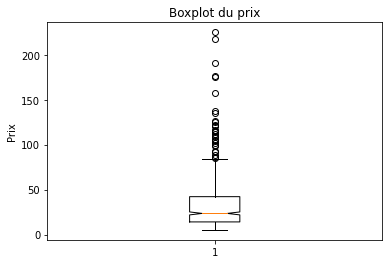

In [9]:
plt.boxplot(df_drop['price'], '0')
plt.ylabel('Prix')
plt.title("Boxplot du prix", loc='center')
plt.show()

##### Méthode visuelle par Nuage de Points : 

<AxesSubplot:xlabel='chiffre_affaire', ylabel='price'>

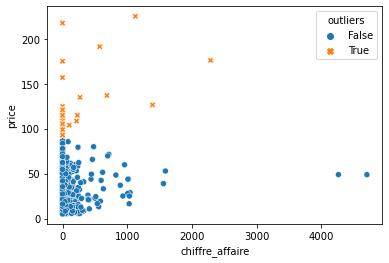

In [10]:
sns.scatterplot(data=df_drop, 
                x="chiffre_affaire", 
                y="price", 
                hue="outliers", 
                style="outliers")

### K-Means

##### Détermination du nombre de clusters :

J'utilise ici la méthode Elbow pour déterminer le nombre de clusters.

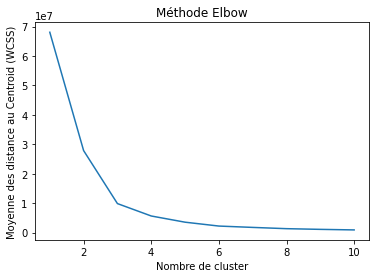

In [11]:
wcss = []
for i in range(1, 11):
  kmeans=KMeans(n_clusters=i, 
                init='k-means++', 
                max_iter= 300, 
                n_init= 10, 
                random_state= 0)
  kmeans.fit(df_drop[['price','chiffre_affaire']])
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 11),wcss)
plt.title('Méthode Elbow')
plt.xlabel('Nombre de cluster')
plt.ylabel('Moyenne des distance au Centroid (WCSS)')  
plt.show()

Il en ressort que le nombre de clusters optimal est 4.

##### Visualisation des clusters :

Comme précédemment vu, l'affichage se fera sur 4 clusters.

Text(0, 0.5, 'Prix')

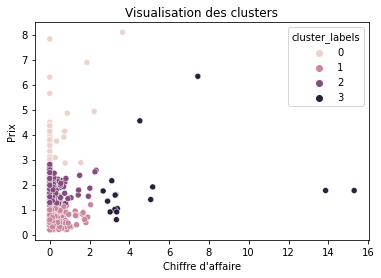

In [16]:
df_drop['x_scaled'] = whiten(df_drop['chiffre_affaire'])
df_drop['y_scaled'] = whiten(df_drop['price'])

cluster_centers, distortions = kmeans(df_drop[['x_scaled', 'y_scaled']], 4)
df_drop['cluster_labels'], distortion_list = vq(df_drop[['x_scaled', 
                                                         'y_scaled']], 
                                                cluster_centers)

sns.scatterplot(x='x_scaled', 
                y='y_scaled', 
                hue='cluster_labels', 
                data=df_drop)
plt.title("Visualisation des clusters")
plt.xlabel("Chiffre d'affaire")
plt.ylabel("Prix")